In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instructions


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


### === Purpose ===

The purpose of this exercise is to solve Weighted MAX SAT problems.

Given a set of rules with weights, the goal of is to find the KB with the highest weight.
If there are several, find the one with the least number of atoms.

input a set of rules:
    
    likesHermioneRon => -likesHermioneHarry [100]
    
    => hermioneIsSmart [1]
    
    hermioneIsSmart & harryIsSmart => likesHermioneHarry [3]
    
    => harryIsSmart [10]
    
    => likesHermioneRon [20]

output the KB with the highest weight (in this case, the weight value is 133.0):

    harryIsSmart
    
    likesHermioneRon

Note: each line is a positive atom, we only output positive ones and assume the other atoms are negative.

### === Provided Data ===

We provide:

1. A set of Max Sat problems (in this folder problem/)
2. a template for your code, max_sat_solver.py
3. For comparison, the weights.txt that our solution achieves on the problems
4. For understanding, we provide an example (exhaustive_search_example) how to use the exhaustive search to solve the above case.


### === Task ===

Complete the max_sat() function.
In order to ensure a fair evaluation, do not use any non-standard Python libraries.


### === Development and Testing ===

We don't provide a standard result but a reference: weights.txt

#### Evaluation

The score on each problem is computed as: 
           
           achieved_weight / total_weight
            
The final score is then computed as an average of scores on each problem.



### === Submission ===

1. Take your code, any necessary resources to run the code, and the folder results/ (no need to put the other datasets!)
2. ZIP these files in a file called firstName_lastName.zip
3. submit it here before the deadline announced during the lab:

https://www.dropbox.com/request/LY77Ysb4FccW12lJF5Ps

### === Contact ===

If you have any additional questions, you can send an email to: nedeljko.radulovic@telecom-paris.fr


# Utils

In [ ]:
'''
Don't modify this file.
Basic tools for this lab.
'''

import re
from threading import Thread
import functools
import os

import pprint 
pp = pprint.PrettyPrinter(indent=0)
from time import time, strftime, gmtime

import matplotlib.pyplot as plt
import numpy as np


class Atom():
    '''
    A logical atom, which can be positive or negative
    '''

    def __init__(self, atom_text):
        # Original atom text
        self.ori_atom = atom_text.strip()

        # Predicate of the atom
        self.predicate = None

        # Polarity of the atom
        self.is_positive_flag = None

        atom_text = atom_text.strip()
        if not re.match('-?[a-zA-Z_0-9]+', atom_text):
            raise Exception('Malformed atom: ' + atom_text)
        if atom_text.startswith('-', 0, 1):
            self.predicate = atom_text[1:]
            self.is_positive_flag = False
        else:
            self.predicate = atom_text
            self.is_positive_flag = True

    def is_positive(self):
        return self.is_positive_flag

    def is_negative(self):
        return not self.is_positive_flag

    def as_positive(self):
        if not self.ori_atom.startswith('-', 0, 1):raise Exception(self.ori_atom + 'is positive already')
        return self.ori_atom[1:]

    def is_satisfied_in(self, kb):
        '''
        TRUE if this atom is satisfied in the KB
        -- either because it appears in the KB or
        because it is negative and does not appear in the KB
        :return: boolean value
        :param kb: a set of atoms
        :return:
        '''

        if self.ori_atom in kb:return True
        if self.is_negative() and self.as_positive() not in kb:return True
        return False


class Clause():

    def __init__(self, rule):
        '''
        Creates a rule from a string of the following forms
        A & B & C => D [#]
        { A, B, C } [#]
        :param rule:
        '''
        # Body atoms
        self.atoms = list()
        # Weight of this rule
        self.weight = 0.0

        re_obj = re.compile('\\[?(\\d+(\\.\\d*)?)\\]? *$')
        match_obj = re.search(re_obj, rule)
        if not match_obj:raise Exception('Rule or clause does not have a weight: '+rule)
        weight = float(match_obj.group(1))
        self.weight = weight
        rule = rule[:match_obj.span()[0]].strip()
        if '=>' in rule:
            hb = rule.split('=>')
            if len(hb) < 2:raise Exception("Rule must contain exactly one '=>': " + rule)
            for a in hb[0].split('&'):
                a = a.strip()
                if a == '':continue
                a = a[1:] if a.startswith('-', 0, 1) else '-' + a
                self.atoms.append(Atom(a))
            self.atoms.append(Atom(hb[1].strip()))
        elif rule[0] == '{' and rule[-1] == '}':
            rule = rule[1:-1]
            for a in rule.split(','):
                self.atoms.append(Atom(a.strip()))

    def is_satisfied_in(self, kb):
        '''
        TRUE if this clause is satisfied in the KB --
        either because a positive atom appears in the KB
        or because a negative atom is absent in the KB.
        :param kb:
        :return:
        '''
        for atom in self.atoms:
            if atom.is_satisfied_in(kb):
                return True
        return False

    def __str__(self):
        result = '{'
        result += ','.join([atom.ori_atom for atom in self.atoms]) + '}'
        result += ' [' + str(self.weight) + ']'
        return result


def read_clause_from_file(file_name):
    '''
    Reads a list of clauses or rules from a file
    :param file_name:
    :return:
    '''
    with open(file_name, encoding='utf8')as f:
        lines = f.readlines()
        clauses = map(Clause, filter(lambda x:not x.startswith('#', 0, 1), lines))
    return list(clauses)


def evaluate(result_path, problem_path):
    '''
    print the weights your solution gets
    :param result_path:
    :param problem_path:
    :return:
    '''
    for root, dirs, files in os.walk(problem_path):
        for name in files:
            result_name = result_path + name.replace('.txt', '.res')
            kb = set([x.predicate for x in map(Atom, open(result_name))])
            clause_name = os.path.join(root, name)
            print(clause_name + ':')
            clauses = read_clause_from_file(clause_name)
            weight = 0.0
            for clause in clauses:

                if clause.is_satisfied_in(kb):
                    weight += clause.weight
            print("  Weight: " + str(weight))


def timeout(timeout):
    '''
    timeout decorater
    :param timeout: how many seconds are allowed
    :return:
    '''
    def deco(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            res = [Exception('function [%s] timeout [%s seconds] exceeded!' % (func.__name__, timeout))]
            def newFunc():
                try:
                    res[0] = func(*args, **kwargs)
                except Exception as e:
                    res[0] = e
            t = Thread(target=newFunc)
            t.daemon = True
            try:
                t.start()
                t.join(timeout)
            except Exception as je:
                print ('error starting thread')
                raise je
            ret = res[0]
            if isinstance(ret, BaseException):
                raise ret
            return ret
        return wrapper
    return deco

In [ ]:
def get_lists(clauses):
  cl, pos, wei = list(), list(), list()
  for c in clauses:
    temp = list()
    temp_pos = list()
    for atom in c.atoms:
      temp.append(atom.predicate)
      temp_pos.append(bool(atom.is_positive()))
    cl.append(temp)
    pos.append(temp_pos)
    wei.append(c.weight)
  return cl, pos, wei

def sorted_lsts(cl, wei, pos):
  sort = sorted(range(len(wei)), key=lambda k: wei[k])
  sorted_cl = [cl[s] for s in sort[::-1]]
  sorted_wei = [wei[s] for s in sort[::-1]]
  sorted_pos = [pos[s] for s in sort[::-1]]
  return sorted_cl, sorted_wei, sorted_pos
  
def find_prop(sorted_cl, prop):
  for i in range(len(sorted_cl)):
    for y in range(len(sorted_cl[i])):
      if sorted_cl[i][y] == prop:
        return i,y
  return None

def poss_gen(halph, sorted_cl):

  #generating all the filtered possible lists
  for x in range(2**halph):
    p=[]
    for y in range(halph):
      if x%(2**y)==0:
        p.append(sorted_cl[y])
      else:
        p.append(sorted_cl[y][::-1])
    p += sorted_cl[halph:]
    yield p

In [ ]:
# import package
import os
from itertools import combinations

# problem path, which includes a set of max sat problem text.
problem_path = 'problems/'
# result path, you should submit this folder
result_path = 'results/'

In [ ]:
def exhaustive_search_example(name_file):
    '''
    an example showing how to use the exhausitive search to solve the problem of 'hermione'
    :return:
    '''

    # read all clauses from this file
    clauses = read_clause_from_file(name_file)

    # get all predicates
    predicates = set([atom.predicate for c in clauses for atom in c.atoms])

    # enumerate all possible sets of atoms
    sub_set = list()
    for i in range(0, len(predicates) + 1):
        temp = [list(x) for x in combinations(predicates, i)]
        sub_set.extend(temp)

    # use a loop to find the best kb
    best_weight, best_kb = 0.0, None
    for sub in sub_set:
        weight = 0.0
        for clause in clauses:
            if clause.is_satisfied_in(sub):
                weight += clause.weight
        if weight > best_weight:
            best_weight = weight
            best_kb = sub
    print('best kb = {a}'.format(a=best_kb))
    print('best weight = {b}'.format(b=best_weight))
    return best_kb

# Prog

## debug

In [ ]:
name_file = 'problems/frb40-19-5.txt'
#getting the data
clauses = read_clause_from_file(name_file)
t = time()
predicates = set([atom.predicate for c in clauses for atom in c.atoms])
cl, pos, wei = get_lists(clauses)
#sorting the lists by weight
sorted_cl, sorted_wei, sorted_pos = sorted_lsts(cl, wei, pos)
sorted_cl, sorted_wei, sorted_pos = sorted_cl[:1000], sorted_wei[:1000], sorted_pos[:1000]
#finding the index of the clause with mean weight
max=sorted_wei[0]
for i, w in enumerate(sorted_wei):
  if w>=max/2:
    halph = i

#finding the optimal set of clauses
best_weight, best_kb = 0.0, None
i=0
for poss in poss_gen(halph, sorted_cl):
  sort_pos = sorted_pos.copy()
  dic = dict.fromkeys(predicates)
  while poss:
    
    props, b = poss[0], sort_pos[0]
    if dic[props[0]]==None:
      dic[props[0]]=b[0]
      while find_prop(poss, props[0]) != None:
        x, y = find_prop(poss, props[0])
        if len(poss[x])==1 or sort_pos[x][y]==b[0]:
          poss.pop(x)
          sort_pos.pop(x)
        else:
          poss[x].pop(y)
          sort_pos[x].pop(y)

  sub = []
  for k, v in dic.items():
    if v==True:
      sub.append(k)

  weight = 0.0
  for clause in clauses:
      if clause.is_satisfied_in(sub):
          weight += clause.weight

  if weight > best_weight:
      best_weight = weight
      best_kb = sub

  i+=1

  if time()-t>5 or best_weight==sum(wei):
    break

print('file:', name_file)
print('went through', i, 'iterations')
print('best kb = {a}'.format(a=best_kb))
print('best weight = {b}'.format(b=best_weight))
score = round(best_weight/sum(wei), 4)*100
print('evaluation mesure =', score)
print('time = ', round(time()-t, 3))
print('\n')

file: problems/frb40-19-5.txt
went through 23 iterations
best kb = []
best weight = 31763379.0
evaluation mesure = 100.0
time =  5.213




## Max Sat

In [ ]:
# Your code goes here
@timeout(5 * 60)
def max_sat(clauses, max_time):
    '''
    Does not take longer than 5 minutes PER PROBLEM,
    otherwise this function will be stopped.
    :param clauses: a list of clauses
    :return:
    '''
    
    t = time()

    predicates = set([atom.predicate for c in clauses for atom in c.atoms])
    cl, pos, wei = get_lists(clauses)

    #sorting the lists by weight
    sorted_cl, sorted_wei, sorted_pos = sorted_lsts(cl, wei, pos)
    #keeping only the first 1000 clauses with highest weights
    sorted_cl, sorted_wei, sorted_pos = sorted_cl[:1000], sorted_wei[:1000], sorted_pos[:1000]

    #finding the index of the clause with mean weight
    max=sorted_wei[0]
    for i, w in enumerate(sorted_wei):
      if w>=max/2:
        halph = i

    #finding the optimal set of clauses
    best_weight, best_kb = 0.0, None
    i=1 #couter for the number of combinations that we go through
    for poss in poss_gen(halph, sorted_cl):
      
      #redundant but if not done => error
      cl, pos, wei = get_lists(clauses)
      sorted_cl, sorted_wei, sorted_pos = sorted_lsts(cl, wei, pos)

      sort_pos = sorted_pos.copy()
      dic = dict.fromkeys(predicates) #dic containing all the predicates with the keys True or False

      while poss:
        #select unit clause with weight=max
        k=0
        props, b = poss[k], sort_pos[k]
        while 

        if dic[props[0]]==None:
          dic[props[0]]=b[0]
          while find_prop(poss, props[0]) != None:
            x, y = find_prop(poss, props[0])
            if len(poss[x])==1 or sort_pos[x][y]==b[0]:
              poss.pop(x)
              sort_pos.pop(x)
            else:
              poss[x].pop(y)
              sort_pos[x].pop(y)

      #Transforming the dictionnary to a list with only the positive predicates
      sub = []
      for k, v in dic.items():
        if v==True:
          sub.append(k)

      #calculating the total weight of the kb found
      weight = 0.0
      for clause in clauses:
          if clause.is_satisfied_in(sub):
              weight += clause.weight

      #did we get better results?
      if weight > best_weight:
          best_weight = weight
          best_kb = sub
          time_best = time()-t
          best_iter = i

      i+=1

      # quick quits if time limit or best kb found
      if (time()-t)>max_time or best_weight==sum(wei):
        break

    return best_kb, round(best_weight/sum(wei), 4)*100, len(wei), best_weight, time()-t, i, time_best, best_iter


def run(max_time):
    '''
    read problem file one by one, and apply your solution to it.
    :return:
    '''
    # create results folder
    if not os.path.exists(result_path):
        os.makedirs(result_path)

    for root, dirs, files in os.walk(problem_path):
        Scores = dict()
        i=0
        for name in files:

            # clause file
            file_name = os.path.join(root, name)

            print('file n°', i)
            i+=1
            print('file:', file_name)

            # load all clauses in this file
            clauses = read_clause_from_file(file_name)

            # execute your solution
            best_kb, score, len, best_weight, time_, iterations, time_best, best_iter = max_sat(clauses, max_time)

            print('went through', iterations, 'iterations')
            print('best kb = {a}'.format(a=best_kb))
            print('best weight = {b}'.format(b=best_weight))
            Scores[file_name]=[best_weight, score, len, time_, time_best, best_iter]
            print('evaluation mesure =', score)
            print('time best = ', time_best)
            print('time = ', strftime('%M:%S', gmtime(time_)))
            print('\n')
            """
            # store the best kb
            with open(result_path+name.replace('.txt', '.res'), 'w', encoding='utf8')as f:
                for atom in best_kb:
                    f.write(atom + '\n')
            """
    return Scores

# Test

## Limit = 0.7s

In [ ]:
Scores = run(0.7)
#evaluate(result_path, problem_path)

file n° 0
file: problems/t3g3-5555.spn.txt
went through 121 iterations
best kb = ['ch', 'ba', 'c', 'ce', 'bi', 'cg', 'cc', 'bb', 'e', 'j', 'bf', 'bh', 'b', 'ca', 'g', 'bc', 'i', 'bg']
best weight = 10388191.0
evaluation mesure = 84.59
time best =  0.011547565460205078
time =  00:00


file n° 1
file: problems/johnson8-2-4.clq.txt
went through 16 iterations
best kb = ['ch', 'cf', 'ce', 'bi', 'cg', 'cc', 'e', 'cd', 'ci', 'bd', 'g', 'd', 'bg']
best weight = 1956.0
evaluation mesure = 80.16
time best =  0.13652729988098145
time =  00:00


file n° 2
file: problems/s2v10c50-8.txt
went through 789 iterations
best kb = ['d', 'h', 'b', 'f', 'g', 'i']
best weight = 239.0
evaluation mesure = 89.51
time best =  0.0015094280242919922
time =  00:00


file n° 3
file: problems/s2v10c50-10.txt
went through 841 iterations
best kb = ['h', 'e', 'ba', 'j', 'f', 'g']
best weight = 226.0
evaluation mesure = 84.00999999999999
time best =  0.0023016929626464844
time =  00:00


file n° 4
file: problems/s2v20c100

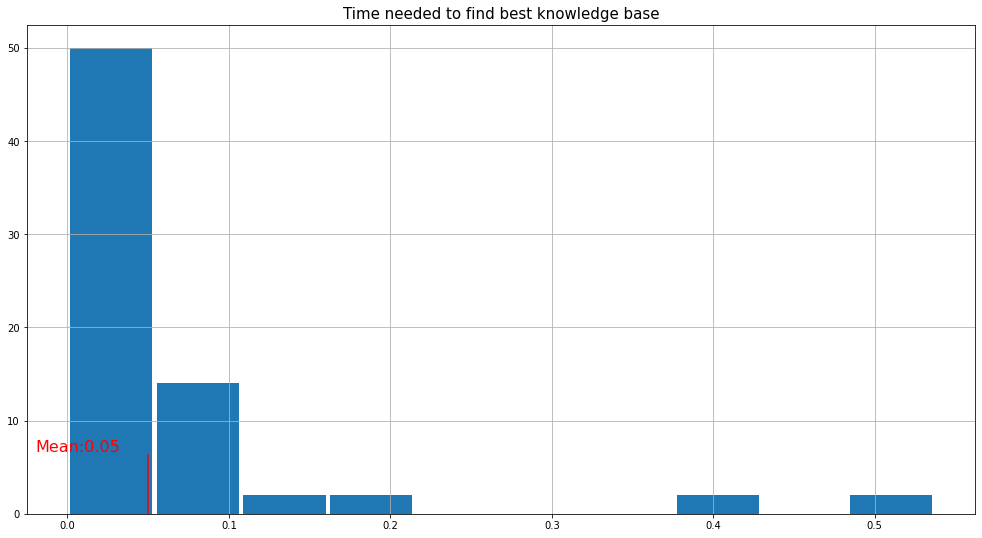

In [ ]:
time_best= [l[4] for l in Scores.values()]

low, high = min(time_best), max(time_best)

mean= sum(time_best)/len(time_best)

plt.figure(figsize=(17,9))
plt.hist(time_best, rwidth=0.95)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean-0.07, 6.7, 'Mean:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.title('Time needed to find best knowledge base', size=15)
plt.show()


In [ ]:
c=0
for i in iter_best:
  if i==1:
    c+=1
c

58

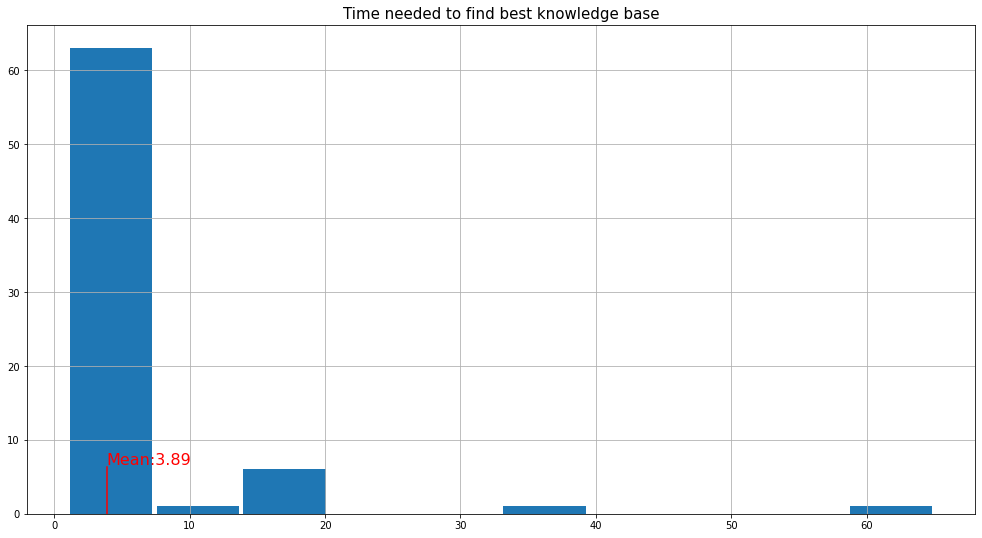

In [ ]:
iter_best= [l[5] for l in Scores.values()]

low, high = min(iter_best), max(iter_best)

mean= sum(iter_best)/len(iter_best)

plt.figure(figsize=(17,9))
plt.hist(iter_best, rwidth=0.95)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean-0.07, 6.7, 'Mean:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.title('Time needed to find best knowledge base', size=15)
plt.show()

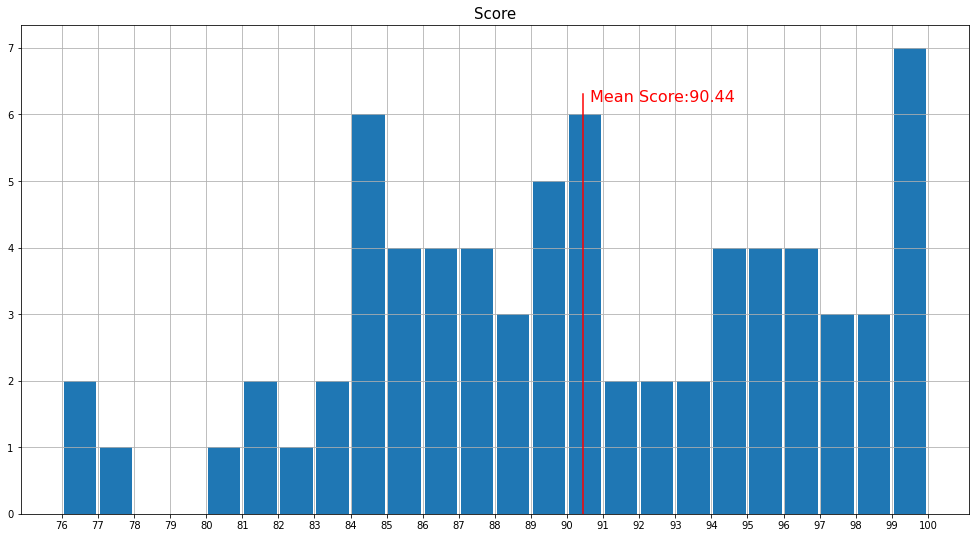

In [ ]:
score= [l[1] for l in Scores.values()]

low, high = int(min(score)), int(max(score))+1
mean= sum(score)/len(score)

plt.figure(figsize=(17,9))
plt.hist(score, bins=range(low,high), rwidth=0.9)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean+0.2, 6.2, 'Mean Score:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.xticks(range(low,high))
plt.title('Score', size=15)
plt.show()

## Limit = 1s

In [ ]:
Scores = run(2)
#evaluate(result_path, problem_path)

file n° 0
file: problems/t3g3-5555.spn.txt
went through 330 iterations
best kb = ['bf', 'ca', 'j', 'e', 'i', 'c', 'bb', 'bg', 'g', 'cc', 'ch', 'bh', 'bi', 'ba', 'ce', 'bc', 'b', 'cg']
best weight = 10388191.0
evaluation mesure = 84.59
time best =  0.012509822845458984
time =  00:02


file n° 1
file: problems/johnson8-2-4.clq.txt
went through 47 iterations
best kb = ['e', 'bg', 'g', 'cc', 'ch', 'ci', 'cf', 'bi', 'bd', 'cd', 'd', 'ce', 'cg']
best weight = 1956.0
evaluation mesure = 80.16
time best =  0.07094478607177734
time =  00:02


file n° 2
file: problems/s2v10c50-8.txt
went through 2241 iterations
best kb = ['i', 'd', 'f', 'h', 'g', 'b']
best weight = 239.0
evaluation mesure = 89.51
time best =  0.001562356948852539
time =  00:02


file n° 3
file: problems/s2v10c50-10.txt
went through 2302 iterations
best kb = ['f', 'h', 'ba', 'g', 'j', 'e']
best weight = 226.0
evaluation mesure = 84.00999999999999
time best =  0.002393960952758789
time =  00:02


file n° 4
file: problems/s2v20c100

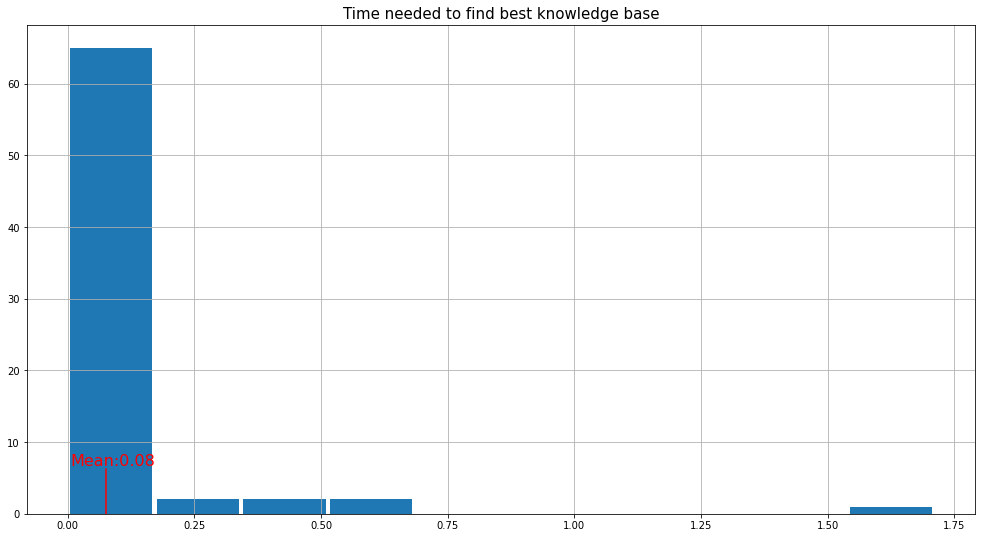

In [ ]:
time_best= [l[4] for l in Scores.values()]

low, high = min(time_best), max(time_best)

mean= sum(time_best)/len(time_best)

plt.figure(figsize=(17,9))
plt.hist(time_best, rwidth=0.95)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean-0.07, 6.7, 'Mean:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.title('Time needed to find best knowledge base', size=15)
plt.show()

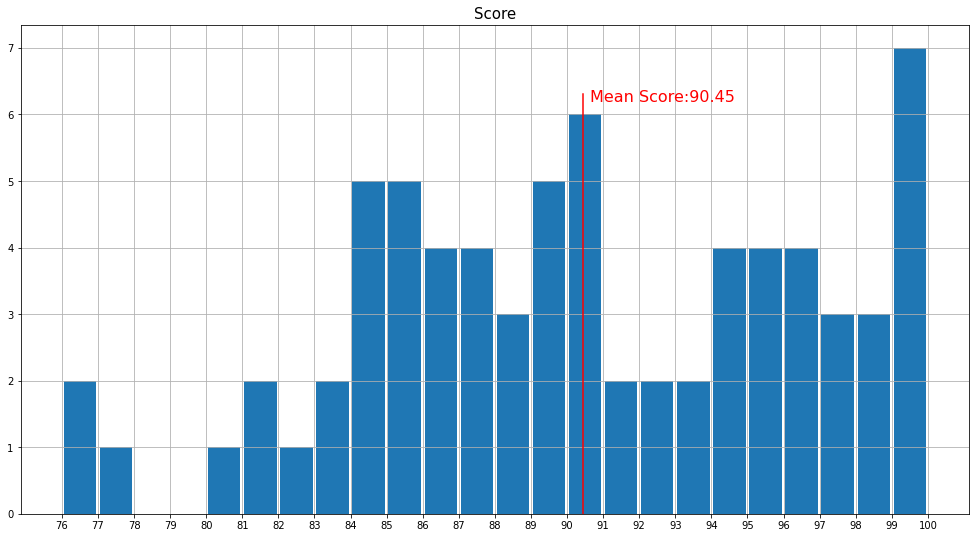

In [ ]:
score= [l[1] for l in Scores.values()]

low, high = int(min(score)), int(max(score))+1
mean= sum(score)/len(score)

plt.figure(figsize=(17,9))
plt.hist(score, bins=range(low,high), rwidth=0.9)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean+0.2, 6.2, 'Mean Score:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.xticks(range(low,high))
plt.title('Score', size=15)
plt.show()

## Limit = 5s

In [ ]:
Scores = run(5)
#evaluate(result_path, problem_path)

file n° 0
file: problems/t3g3-5555.spn.txt
went through 855 iterations
best kb = ['bf', 'ca', 'j', 'e', 'i', 'c', 'bb', 'bg', 'g', 'cc', 'ch', 'bh', 'bi', 'ba', 'ce', 'bc', 'b', 'cg']
best weight = 10388191.0
evaluation mesure = 84.59
time =  00:05


file n° 1
file: problems/johnson8-2-4.clq.txt
went through 122 iterations
best kb = ['e', 'bg', 'g', 'cc', 'ch', 'ci', 'cf', 'bi', 'bd', 'cd', 'd', 'ce', 'cg']
best weight = 1956.0
evaluation mesure = 80.16
time =  00:05


file n° 2
file: problems/s2v10c50-8.txt
went through 5729 iterations
best kb = ['i', 'd', 'f', 'h', 'g', 'b']
best weight = 239.0
evaluation mesure = 89.51
time =  00:05


file n° 3
file: problems/s2v10c50-10.txt
went through 5936 iterations
best kb = ['f', 'h', 'ba', 'g', 'j', 'e']
best weight = 226.0
evaluation mesure = 84.00999999999999
time =  00:05


file n° 4
file: problems/s2v20c100-3.txt
went through 1522 iterations
best kb = ['bf', 'ca', 'e', 'i', 'f', 'c', 'h', 'bb', 'g', 'bd', 'bj', 'd', 'be', 'b']
best weight

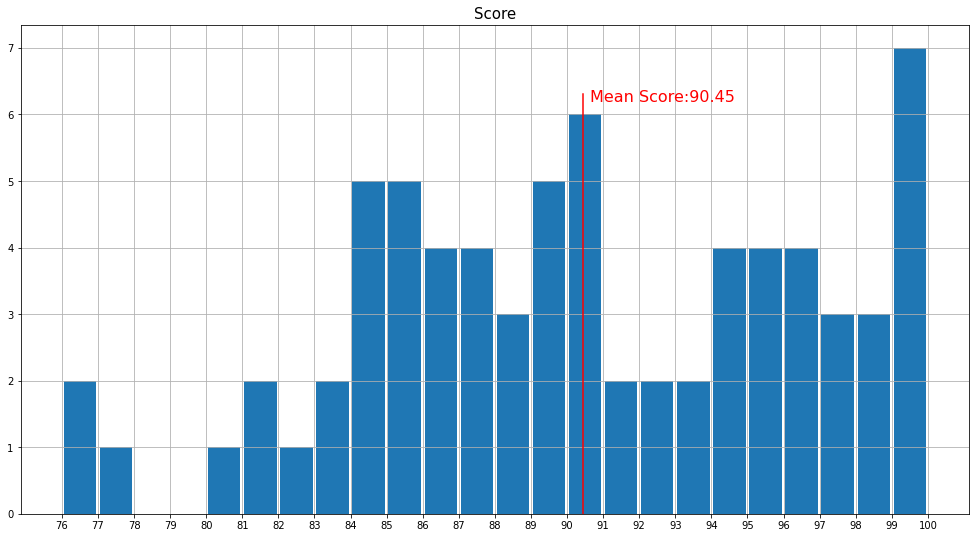

In [ ]:
score= [l[1] for l in Scores.values()]

low, high = int(min(score)), int(max(score))+1
mean= sum(score)/len(score)

plt.figure(figsize=(17,9))
plt.hist(score, bins=range(low,high), rwidth=0.9)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean+0.2, 6.2, 'Mean Score:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.xticks(range(low,high))
plt.title('Score', size=15)
plt.show()

## Limit = 30s

In [ ]:
Scores = run(.5*60)
#evaluate(result_path, problem_path)

file n° 0
file: problems/t3g3-5555.spn.txt
went through 5258 iterations
best kb = ['bg', 'cc', 'cg', 'g', 'e', 'ce', 'ch', 'bh', 'bf', 'j', 'bi', 'bb', 'b', 'ca', 'bc', 'c', 'i', 'ba']
best weight = 10388191.0
evaluation mesure = 84.59
time =  00:30


file n° 1
file: problems/johnson8-2-4.clq.txt
went through 724 iterations
best kb = ['bd', 'bg', 'cc', 'cg', 'g', 'cf', 'e', 'ci', 'ce', 'ch', 'bi', 'd', 'cd']
best weight = 1956.0
evaluation mesure = 80.16
time =  00:30


file n° 2
file: problems/s2v10c50-8.txt
went through 34248 iterations
best kb = ['f', 'i', 'g', 'h', 'd', 'b']
best weight = 239.0
evaluation mesure = 89.51
time =  00:30


file n° 3
file: problems/s2v10c50-10.txt
went through 35549 iterations
best kb = ['j', 'f', 'ba', 'g', 'e', 'h']
best weight = 226.0
evaluation mesure = 84.00999999999999
time =  00:30


file n° 4
file: problems/s2v20c100-3.txt
went through 9064 iterations
best kb = ['bj', 'be', 'bd', 'g', 'e', 'h', 'bf', 'bb', 'd', 'ca', 'b', 'f', 'c', 'i']
best wei

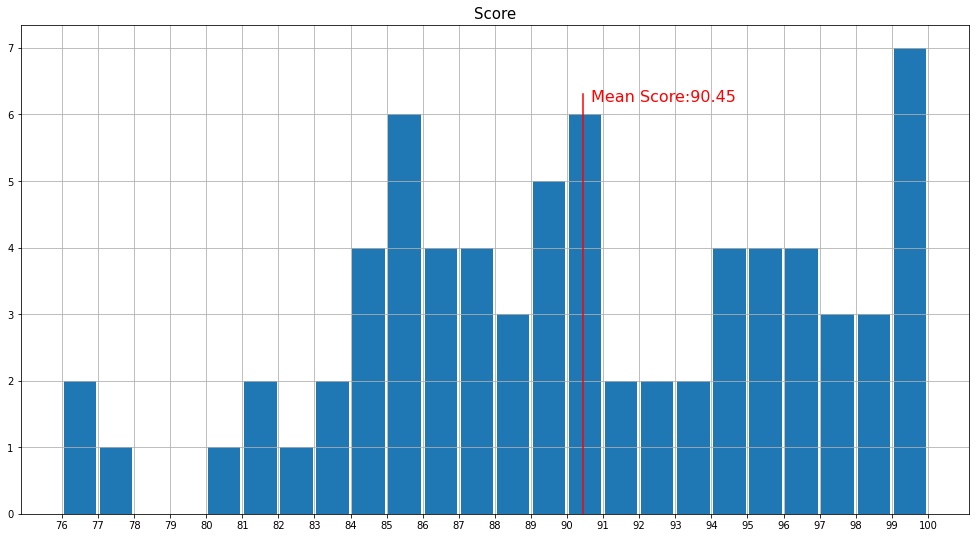

In [ ]:
score= [l[1] for l in Scores.values()]

low, high = int(min(score)), int(max(score))+1
mean= sum(score)/len(score)

plt.figure(figsize=(17,9))
plt.hist(score, bins=range(low,high), rwidth=0.9)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean+0.2, 6.2, 'Mean Score:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.xticks(range(low,high))
plt.title('Score', size=15)
plt.show()

## Limit = 4.97min

In [ ]:
Scores = run(4.97*60)

file n° 0
file: problems/t3g3-5555.spn.txt
went through 52457 iterations
best kb = ['bh', 'cg', 'ba', 'e', 'i', 'ch', 'g', 'c', 'bi', 'bc', 'b', 'ca', 'ce', 'cc', 'bf', 'bg', 'bb', 'j']
best weight = 10388191.0
evaluation mesure = 84.59
time =  04:58


file n° 1
file: problems/johnson8-2-4.clq.txt
went through 7229 iterations
best kb = ['cg', 'd', 'cd', 'bd', 'e', 'ch', 'bi', 'ce', 'cc', 'cf', 'ci', 'bg', 'g']
best weight = 1956.0
evaluation mesure = 80.16
time =  04:58


file n° 2
file: problems/s2v10c50-8.txt
went through 338382 iterations
best kb = ['b', 'i', 'd', 'f', 'h', 'g']
best weight = 239.0
evaluation mesure = 89.51
time =  04:58


file n° 3
file: problems/s2v10c50-10.txt
went through 352234 iterations
best kb = ['e', 'g', 'f', 'h', 'j', 'ba']
best weight = 226.0
evaluation mesure = 84.00999999999999
time =  04:58


file n° 4
file: problems/s2v20c100-3.txt
went through 90109 iterations
best kb = ['d', 'bj', 'bd', 'e', 'i', 'c', 'be', 'b', 'ca', 'bb', 'bf', 'f', 'h', 'g']
bes

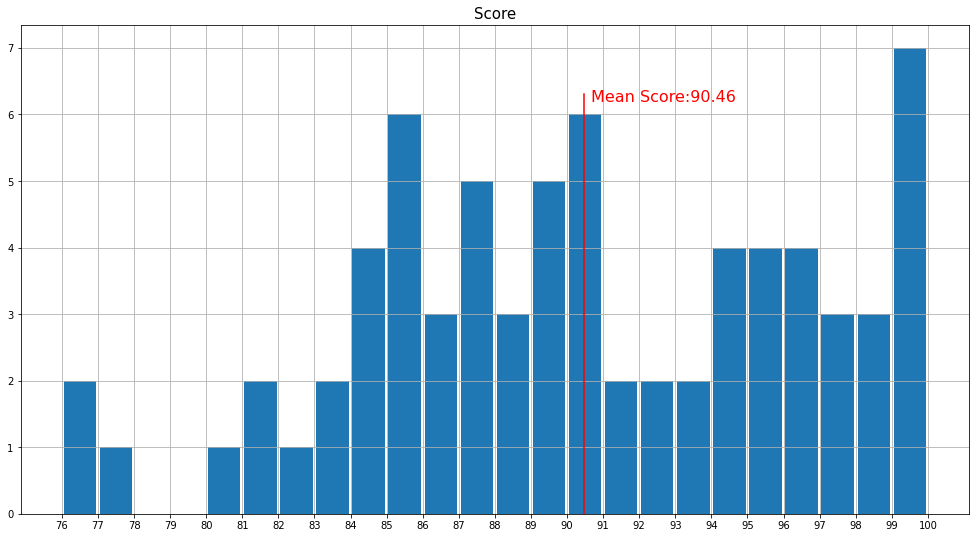

In [ ]:
score= [l[1] for l in Scores.values()]

low, high = int(min(score)), int(max(score))+1
mean= sum(score)/len(score)

plt.figure(figsize=(17,9))
plt.hist(score, bins=range(low,high), rwidth=0.9)

plt.plot([mean,mean], [0, 6.3], color='r')
plt.text(mean+0.2, 6.2, 'Mean Score:'+str(round(mean, 2)), color='r', size=16)
plt.grid()
plt.xticks(range(low,high))
plt.title('Score', size=15)
plt.show()